# Example: Decaying Turbulence

In [1]:
import lettuce as lt
import matplotlib.pyplot as plt
import numpy as np
import torch

## Setup
The dimension of DecayingTurbulence vortex is defined by the stencil. Here the flow is two dimensional due to D2Q9. Special Inputs & standard values that can be set in the flow constructor are ...
* the wavenumber_energy-peak k0 (= 20 as default) 
* the initial_energy (= 0.5 as default)

In [2]:
context = lt.Context(device=torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu'),
                     dtype=torch.float32, use_native=True)
flow = lt.DecayingTurbulence(context=context, resolution=256,
                             reynolds_number=10000, mach_number=0.05,
                             stencil=lt.D2Q9())
energyreporter = lt.ObservableReporter(lt.EnergySpectrum(flow), interval=500, 
                                  out=None)
simulation = lt.Simulation(flow=flow,
                           collision=lt.BGKCollision(flow.units.relaxation_parameter_lu),
                           boundaries=[], reporter=[energyreporter])

/home/philipp/lettuce/lettuce/_context.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(array, *args, **kwargs, device=self.device, dtype=self.dtype)
/home/philipp/anaconda3/envs/lettuce/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905971214/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


steps     time     EnergySpectrum
Could not resolve native extension.
Installing Native module (/tmp/tmpn8i34i00) ...


### Initialized flow
The initialized velocity is randomly generated and depends on the wavenumber peak k0, the initial energy, which are given in the flow constructor, and a given energy spectrum.

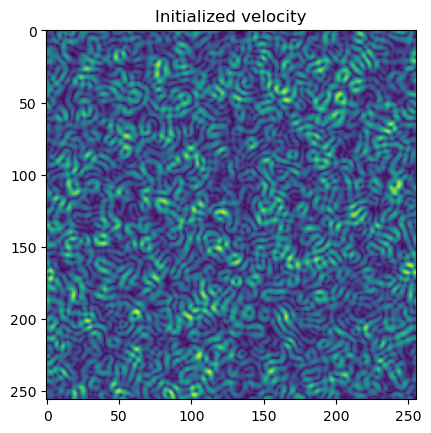

In [3]:
u = flow.u_pu.cpu().numpy()
u_norm = np.linalg.norm(u, axis=0)
plt.imshow(u_norm)
plt.title('Initialized velocity')
plt.show()

### Energy spectrum
The energy spectrum, which is forced in the beginning is given with:

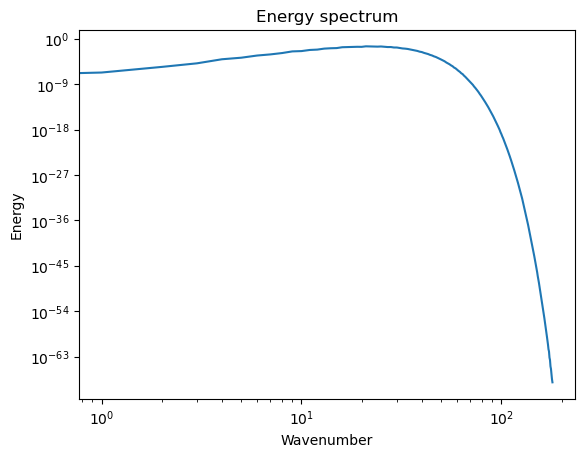

In [4]:
spectrum = flow.energy_spectrum
plt.loglog(spectrum[1],spectrum[0])
plt.title('Energy spectrum')
plt.xlabel('Wavenumber')
plt.ylabel('Energy')
plt.show()

## Run simulation
Before the simulation is executed, the pressure field is obtained by solving the pressure poisson equation. In addition, f_neq is initialized to obtain stress tensor at the start of the simulation.

In [5]:
mlups = simulation(num_steps=15000)
print("Performance in MLUPS:", mlups)

Performance in MLUPS: 339.21303174975543


### Velocity
* Velocity field after the simulation

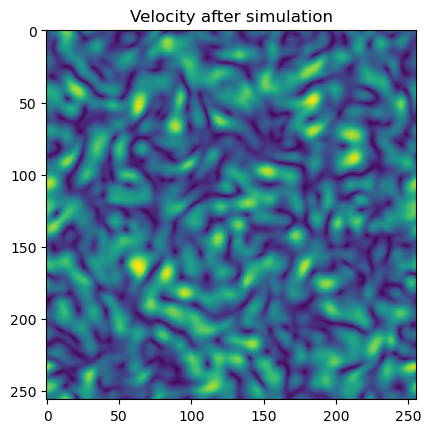

In [6]:
u = flow.u_pu.cpu().numpy()
u_norm = np.linalg.norm(u, axis=0)
plt.imshow(u_norm)
plt.title('Velocity after simulation')
plt.show()

### Vorticity
* Vorticity field after the simulation

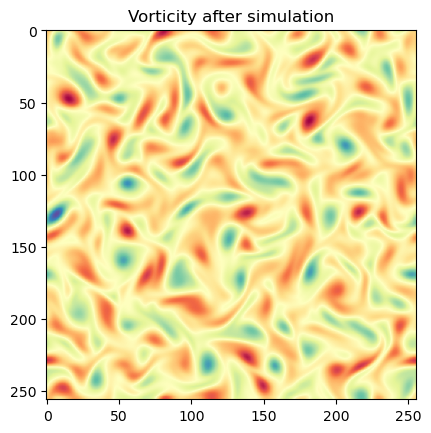

In [7]:
dx = flow.units.convert_length_to_pu(1.0)
grad_u0 = np.gradient(u[0], dx)
grad_u1 = np.gradient(u[1], dx)
vorticity = (grad_u1[0] - grad_u0[1])
plt.imshow(vorticity, cmap='Spectral')
plt.title('Vorticity after simulation')
plt.show()

### Energy spectrum after simulation

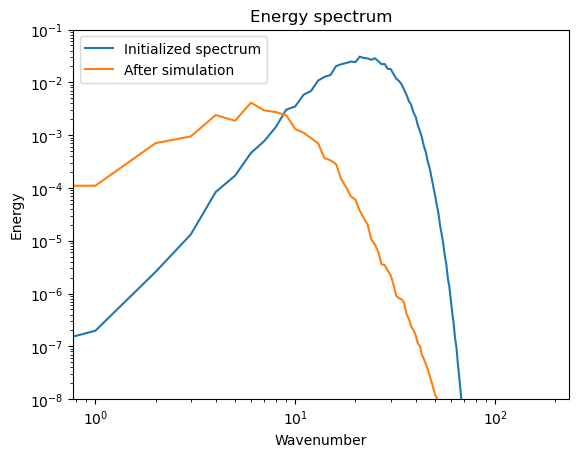

In [8]:
spectrum_final = simulation.reporter[0].out[-1]
plt.loglog(spectrum[1],spectrum[0],label='Initialized spectrum')
plt.loglog(spectrum[1],spectrum_final[2:],label='After simulation')
plt.title('Energy spectrum')
plt.xlabel('Wavenumber')
plt.ylabel('Energy')
plt.ylim(top=1e-1, bottom=1e-8)
plt.legend()
plt.show()